# Adaptive gains
This script will see how the adaptive algorithm out-preforms the passive algorithm.

It does this by seeing how many rankings are considered the funniest ranking. For each caption we have a mean and a standard deviation. If the first rated caption has mean $\mu_1$ and std.dev. of $\sigma_1$, we want how many captions $i$ have $\mu_i + \sigma_i > \mu_1 - \sigma_1$.

## Obtaining the data

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def read_csv(filename, columns=6, time_format='%Y-%m-%d %H:%M:%S.%f'):
    with open(filename, 'r') as f:
        contents = f.readlines()
    for i, line in enumerate(contents):
        line = line.split(',', maxsplit=columns)
        line[-1] = line[-1][:-1]  # remove newline
        
        if line[3] != 'Timestamp':
            line[3] = datetime.strptime(line[3], time_format) 
        contents[i] = line
    
    return pd.DataFrame(contents[1:], columns=contents[0])

In [190]:
contest = '519'
filename = '../contests/passive+adaptive/{}/participant-responses.csv'

df = read_csv(filename.format(contest))
df = df.sort_values(by='Timestamp')
df.head()

,Partipipant ID,Response Time (s),Network Delay (s),Timestamp,Rating,Alg label,Target
140793,J2IRIqVgmQ0IuP9C8xiOJI9c1usH1K,18.287,0.19513700000000256,2016-04-25 16:18:25.909958,1.0,LilUCB,This ought to be good. I told him he's a prote...
140794,J2IRIqVgmQ0IuP9C8xiOJI9c1usH1K,2.827,0.09565899999999994,2016-04-25 16:18:44.728593,1.0,LilUCB,The old birds are tricky.
140795,J2IRIqVgmQ0IuP9C8xiOJI9c1usH1K,4.018,0.08863999999999983,2016-04-25 16:18:47.975493,2.0,LilUCB,He's never been clear on the decoy concept.
74112,HXWpEcL3w1PZi1MumTTccmfSZn5ZTT,8.905,0.08309100000000136,2016-04-25 16:22:41.837991,1.0,LilUCB,That little bird won't tell him very much if h...
74113,HXWpEcL3w1PZi1MumTTccmfSZn5ZTT,2.233,0.09227600000000002,2016-04-25 16:22:51.155561,1.0,RoundRobin,He doesn't play well with others.


## Finding the mean and number of possible top captions 
Another implementation can be found in `/summary-stats/summary-stats-v2.py`.

In [199]:
def calculate_stats(alg_ratings):
    df = pd.DataFrame(alg_ratings).T
    n = df['responses']
    df['mean'] = df['1.0'] + 2 * df['2.0'] + 3 * df['3.0']
    df['mean'] /= n
    
    reward = df['1.0'] + 2*df['2.0'] + 3*df['3.0']
    reward2 = df['1.0'] + 4*df['2.0'] + 9*df['3.0']
    
    top = np.maximum(1, reward2 - reward**2 / n)
    bottom = (n - 1) * n
    
    df['prec'] = np.sqrt(top / bottom)
    return df

def find_top_captions(alg_ratings):
    """ alg_ratings : dict """
    df = calculate_stats(alg_ratings)
    i_top_mean = df['mean'].idxmax()
    top_caption = df.T[i_top_mean]
    min_rating = top_caption['mean'] - top_caption['prec']
    df['upper bound'] = df['mean'] + df['prec']
    return (df['upper bound'] > min_rating).sum()

## Initializing responses
These are the variables we will count the responses in

In [200]:
caption_map = {caption: i for i, caption in enumerate(df['Target'].unique())}

In [201]:
ratings = {'LilUCB': {}, 'RoundRobin': {}}
for i, response in df.iterrows():
#     df.T[i]['Rating'] = int(float(response['Rating']))
    if caption_map[response['Target']] not in ratings['LilUCB']:
        caption = response['Target']
        ratings['LilUCB'][caption_map[caption]]     = {'1.0': 0, '2.0': 0, '3.0': 0, 'responses': 0, 'mean': np.nan} 
        ratings['RoundRobin'][caption_map[caption]] = {'1.0': 0, '2.0': 0, '3.0': 0, 'responses': 0, 'mean': np.nan} 

## Replaying the simulation

In [202]:
performance = [] 
responses = {'LilUCB': 0, 'RoundRobin': 0}
j = 0
for _, response in df.iterrows():
    if j > 2:
        assert last_response['Timestamp'] <= response['Timestamp']
    caption = caption_map[response['Target']]
    rating = response['Rating']
    alg = response['Alg label']
    ratings[alg][caption][rating] += 1
    ratings[alg][caption]['responses'] += 1
    responses[alg] += 1
    if j / len(caption_map) > 1 and j % len(caption_map) == 0:
        performance += [{'top captions': find_top_captions(ratings[key]),
                         'responses': responses[alg],
                         'algorithm': key}
                        for key in ['LilUCB', 'RoundRobin']]
    last_response = response
    j += 1

In [203]:
performance = pd.DataFrame(performance)
performance.head()

,algorithm,responses,top captions
0,LilUCB,4635,4614
1,RoundRobin,4635,4499
2,LilUCB,6907,3937
3,RoundRobin,6907,4551
4,LilUCB,9287,2727


## Visualization
This means that LilUCB saw ~10 captions that could be the funniest, and RoundRobin saw ~50 captions that could be the funniest. 

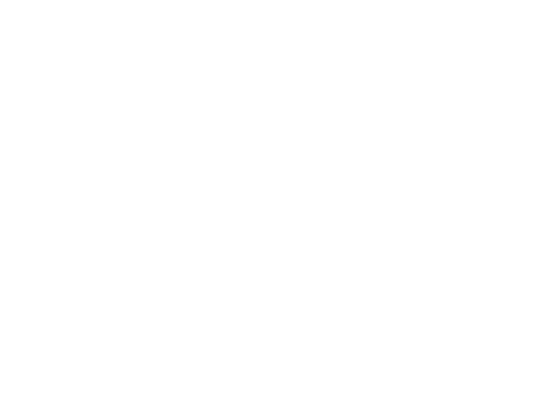

In [204]:
from altair import Chart, Y, Scale

Chart(performance).mark_line().encode(
    x='responses', y=Y('top captions', scale=Scale(type='log')), color='algorithm')

In [205]:
df_ = performance.pivot_table(index='responses', columns='algorithm', values='top captions')

In [206]:
df_

algorithm,LilUCB,RoundRobin
responses,,
4635,4614,4499
6907,3937,4551
9287,2727,532
11478,1469,4614
13781,282,384
16237,313,220
18523,194,579
20682,252,200
22998,171,158
